<a href="https://www.kaggle.com/code/mariamelghandoor/paper-1?scriptVersionId=237474966" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# COVID-19 detection using chest X-ray images based on a developed deep neural network
 [**Paper Link**](https://doi.org/10.1016/j.slast.2021.10.011)

# Imports and Installs

In [1]:
!pip install lime

In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LSTM, Dense, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow as tf


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries


from shutil import copyfile
import pandas as pd
import numpy as np 
import cv2
import os

2025-05-02 21:35:04.521261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746221704.722033      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746221704.783358      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Helper Functions

In [3]:
def preprocess_image(image_path):
    try:
        img = imread(image_path, as_gray=False)
        img = resize(img, (224, 224), anti_aliasing=True)
        if len(img.shape) == 2:
            img_rgb = np.stack([img] * 3, axis=-1)
        elif img.shape[-1] == 1:
            img_rgb = np.repeat(img, 3, axis=-1)
        else:
            img_rgb = img
        img_normalized = img_rgb / 255.0 if img_rgb.max() > 1 else img_rgb
        if len(img.shape) == 2 or (len(img.shape) == 3 and np.all(img[:, :, 0] == img[:, :, 1]) and np.all(img[:, :, 1] == img[:, :, 2])):
            img_viz = img if len(img.shape) == 2 else img[:, :, 0]
        else:
            img_viz = img_rgb
        return img_normalized, img_viz
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None, None


In [4]:
def split_train_val(data_dir, output_dir, train_ratio=0.875):  # 70/(70+10) = 0.875
    classes = ['covid19', 'normal', 'pneumonia']
    os.makedirs(output_dir, exist_ok=True)
    
    for split in ['train', 'val']:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)
    
    for cls in classes:
        class_dir = os.path.join(data_dir, cls)
        images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        train_imgs, val_imgs = train_test_split(images, train_size=train_ratio, random_state=42)
        
        for img in train_imgs:
            copyfile(os.path.join(class_dir, img), os.path.join(output_dir, 'train', cls, img))
        for img in val_imgs:
            copyfile(os.path.join(class_dir, img), os.path.join(output_dir, 'val', cls, img))
    
    print("Train-validation split completed.")

# plotting functions for train test tracing

In [5]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [6]:
def plot_multiclass_roc_pr(y_true, y_probs, class_names):
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    plt.figure(figsize=(14, 6))

    # ROC Curves
    plt.subplot(1, 2, 1)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('Multiclass ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # PR Curves
    plt.subplot(1, 2, 2)
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f"{class_names[i]} (AP = {ap:.2f})")
    plt.title('Multiclass Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [7]:
def plot_confusion_matrix(model, test_generator):
    Y_true = test_generator.classes
    Y_pred_probs = model.predict(test_generator)
    Y_pred = np.argmax(Y_pred_probs, axis=1)

    cm = confusion_matrix(Y_true, Y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

In [8]:
def predict_fn(images):
    images = np.array(images)
    if images.shape[-1] != 3:
        images = np.repeat(images, 3, axis=-1)
    images = np.clip(images, 0, 1)
    return model.predict(images, verbose=0)

# XAI functions for imgs

In [9]:
def explain_with_lime(model, image_paths_with_labels):
    explainer = lime_image.LimeImageExplainer()
    segmenter = SegmentationAlgorithm('quickshift', kernel_size=2, max_dist=100, ratio=0.2)

    for image_path, class_name in image_paths_with_labels:
        img_normalized, img_viz = preprocess_image(image_path)
        if img_normalized is None:
            print(f"Skipping {image_path} due to preprocessing error.")
            continue

        try:
            explanation = explainer.explain_instance(
                img_normalized,
                predict_fn,
                top_labels=3,
                hide_color=None,
                num_samples=500,
                segmentation_fn=segmenter
            )
        except Exception as e:
            print(f"Error explaining image {image_path}: {e}")
            continue

        pred = model.predict(np.expand_dims(img_normalized, axis=0), verbose=0)
        predicted_class = class_labels[np.argmax(pred)]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        ax1.imshow(img_viz, cmap='gray' if len(img_viz.shape) == 2 else None)
        ax1.set_title(f'Original ({class_name})\nPredicted: {predicted_class}')
        ax1.axis('off')

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )

        base_image = img_viz
        if len(base_image.shape) == 2:
            overlay = np.zeros_like(base_image)
            overlay[mask == 1] = 1
            alpha = 0.3
            highlighted_image = (1 - alpha) * base_image + alpha * overlay
            highlighted_image = np.clip(highlighted_image, 0, 1)
            cmap = 'gray'
        else:
            overlay = np.zeros_like(base_image)
            overlay[mask == 1] = [1, 0, 0]
            alpha = 0.3
            highlighted_image = (1 - alpha) * base_image + alpha * overlay
            highlighted_image = np.clip(highlighted_image, 0, 1)
            cmap = None

        highlighted_image = mark_boundaries(highlighted_image, mask, color=(1, 0, 0), mode='thick')
        ax2.imshow(highlighted_image, cmap=cmap)
        ax2.set_title('LIME Highlights')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Image: {image_path}")
        print(f"Predicted probabilities: {dict(zip(class_labels, pred[0]))}\n")

In [10]:
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    try:
        conv_layer = model.get_layer(last_conv_layer_name)
    except ValueError:
        print("Available layers:")
        for layer in model.layers:
            print(layer.name)
        raise ValueError(f"Layer '{last_conv_layer_name}' not found in the model. Check layer names above.")

    grad_model = Model(
        inputs=[model.inputs],
        outputs=[conv_layer.output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Apply ReLU and normalize the heatmap
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.math.reduce_max(heatmap)
    if max_val > 0:
        heatmap = heatmap / max_val
    else:
        print("Warning: Heatmap is all zeros, returning empty heatmap")
        heatmap = np.zeros_like(heatmap)
    return heatmap.numpy()

def overlay_heatmap(heatmap, original_img, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    if original_img.max() <= 1.0:
        original_img = original_img * 255
    original_img = np.uint8(original_img)
    
    superimposed_img = heatmap * alpha + original_img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

def apply_grad_cam(model, image_path, class_label, class_labels, last_conv_layer_name='conv2d_19', save_dir='.'):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image from {image_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    sample_img = img.astype(np.float32) / 255.0
    sample_img_array = np.expand_dims(sample_img, axis=0)

    print(f"\nProcessing image: {image_path}")
    print("Sample image shape:", sample_img.shape)
    print("Sample image min/max:", sample_img.min(), sample_img.max())
    if sample_img_array.shape != (1, 224, 224, 3):
        raise ValueError(f"Sample image shape {sample_img_array.shape} does not match expected shape (1, 224, 224, 3)")

    predictions = model.predict(sample_img_array, verbose=1)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_idx]
    print("Predicted class:", predicted_class)
    print("Predictions:", predictions[0])

    heatmap = get_gradcam_heatmap(model, sample_img_array, last_conv_layer_name, pred_index=predicted_class_idx)
    print("Heatmap shape:", heatmap.shape)
    print("Heatmap min/max:", heatmap.min(), heatmap.max())

    superimposed_img = overlay_heatmap(heatmap, sample_img)


    plt.subplot(1, 2, 1)
    plt.title(f'Original Image\n(True: {class_label})')
    plt.imshow(sample_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f'Grad-CAM\n(Pred: {predicted_class})')
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.tight_layout()

    save_filename = f'grad_cam_{class_label}.png'
    save_path = os.path.join(save_dir, save_filename)
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Plot saved to: {os.path.abspath(save_path)}")

    plt.show()

    plt.close()


In [11]:
def deeplift(model, img, baseline=None, pred_index=None):
    if baseline is None:
        baseline = np.zeros_like(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
    
    diff = img - baseline
    
    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        score = preds[:, pred_index]
    
    grads = tape.gradient(score, img)
    multipliers = grads
    contributions = diff * multipliers  
    heatmap = tf.reduce_sum(tf.abs(contributions), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10) 
    return heatmap, pred_index

def display_heatmap(img, heatmap, alpha=0.5):
    if img.ndim == 4:
        img = img[0]
    if heatmap.ndim == 3:
        heatmap = heatmap[0]
    
    img = np.uint8(255 * (img - img.min()) / (img.max() - img.min() + 1e-10))
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy()[..., 0]
    heatmap = np.uint8(plt.cm.jet(heatmap)[..., :3] * 255)
    
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    return np.uint8(superimposed_img)

In [12]:
def permutation_importance(image, model, class_index, model_name, raw_image, patch_size=32):
    image = np.expand_dims(image, axis=0)
    correct_prob = model.predict(image, verbose=0)[0, class_index]

    h, w = image.shape[1], image.shape[2]
    importance_map = np.zeros((h // patch_size, w // patch_size))

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            permuted = image.copy()

            for c in range(3):
                permuted[0, i:i+patch_size, j:j+patch_size, c] = np.random.rand(patch_size, patch_size)

            pred_prob = model.predict(permuted, verbose=0)[0, class_index]
            importance = correct_prob - pred_prob
            importance_map[i // patch_size, j // patch_size] = importance

    importance_map = (importance_map - importance_map.min()) / (importance_map.max() - importance_map.min() + 1e-8)

    heatmap = cv2.resize(importance_map, (w, h))

    plt.figure(figsize=(6, 6))
    plt.imshow(raw_image)
    plt.imshow(heatmap, cmap='hot', alpha=0.5)
    plt.title(f"{model_name}")
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()
    plt.show()


# Load data and apply Augmentation

In [13]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_281.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_1.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_256.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_221.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_138.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_93.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_198.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_137.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_120.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_13.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_40.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_217.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_3.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_286.png
/kaggle/input/feature-selelcted-dataset/t

In [14]:
train_dir = '/kaggle/input/feature-selelcted-dataset/train'
output_dir = '/kaggle/working/chest-xray-covid19-pneumonia/split'
split_train_val(train_dir, output_dir)
test_dir = '/kaggle/input/feature-selelcted-dataset/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    classes=['covid19', 'normal', 'pneumonia']
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    classes=['covid19', 'normal', 'pneumonia']
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    classes=['covid19', 'normal', 'pneumonia'],
    shuffle=False
)


Train-validation split completed.
Found 1052 images belonging to 3 classes.
Found 153 images belonging to 3 classes.
Found 302 images belonging to 3 classes.


# Model

In [15]:
def create_cnn_lstm_model(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Convolutional Block 1
    x = Conv2D(filters=16, kernel_size=(128, 128), strides=(6, 6), padding='same',
               activation='leaky_relu', name='conv2d_15')(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pooling2d_15')(x)
    x = BatchNormalization(name='batch_normalization_18')(x)

    # Convolutional Block 2
    x = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
               activation='leaky_relu', name='conv2d_16')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pooling2d_16')(x)
    x = BatchNormalization(name='batch_normalization_19')(x)

    # Convolutional Block 3
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
               activation='leaky_relu', name='conv2d_17')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pooling2d_17')(x)
    x = BatchNormalization(name='batch_normalization_20')(x)

    # Convolutional Block 4
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
               activation='leaky_relu', name='conv2d_18')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pooling2d_18')(x)
    x = BatchNormalization(name='batch_normalization_21')(x)

    # Convolutional Block 5
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
               activation='leaky_relu', name='conv2d_19')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pooling2d_19')(x)
    x = BatchNormalization(name='batch_normalization_22')(x)

    # Reshape for LSTM input
    x = Reshape((1, 64), name='reshape_3')(x)

    # LSTM Layers
    x = LSTM(60, return_sequences=True, activation='leaky_relu', name='lstm_9')(x)
    x = LSTM(60, return_sequences=True, activation='leaky_relu', name='lstm_10')(x)
    x = LSTM(60, activation='leaky_relu', name='lstm_11')(x)
    x = BatchNormalization(name='batch_normalization_23')(x)

    # Fully Connected Layers
    x = Dropout(0.5, name='dropout_3')(x)
    x = Dense(50, activation='leaky_relu', name='dense_6')(x)
    outputs = Dense(num_classes, activation='softmax', name='dense_7')(x)

    # Create Functional model
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [16]:
model = create_cnn_lstm_model(input_shape=(224, 224, 3), num_classes=3)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='mse', metrics=['accuracy'])

model.summary()

I0000 00:00:1746221732.215902      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746221732.216600      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 38, 38, 16)          │         786,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 19, 19, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 19, 19, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 19, 19, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 9, 9, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 9, 9, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 9, 9, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 2, 2, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 2, 2, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 1, 1, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 1, 60)               │          30,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 1, 60)               │          29,0

 Total params: 975,923 (3.72 MB)

 Trainable params: 975,323 (3.72 MB)

 Non-trainable params: 600 (2.34 KB)

# Train and Test

In [17]:
history = model.fit(
    train_generator,
    epochs=400,
    validation_data=validation_generator
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


# model.save('/kaggle/working/cnn_lstm_pneumonia_model.h5')

Epoch 1/400


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746221743.082508     122 service.cc:148] XLA service 0x1ec3ca70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746221743.083253     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746221743.083275     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746221743.893605     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/106 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.3250 - loss: 0.2221  

I0000 00:00:1746221750.186365     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 35s 178ms/step - accuracy: 0.4710 - loss: 0.2092 - val_accuracy: 0.3333 - val_loss: 0.2225
Epoch 2/400
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.5781 - loss: 0.1807 - val_accuracy: 0.3333 - val_loss: 0.2249
Epoch 3/400
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - accuracy: 0.6183 - loss: 0.1646 - val_accuracy: 0.3464 - val_loss: 0.2121
Epoch 4/400
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.6399 - loss: 0.1547 - val_accuracy: 0.6340 - val_loss: 0.1609
Epoch 5/400
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.6596 - loss: 0.1509 - val_accuracy: 0.6601 - val_loss: 0.1347
Epoch 6/400
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.6564 - loss: 0.1519 - val_accuracy: 0.6013 - val_loss: 0.1528
Epoch 7/400
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.6486 - loss: 0.1528 - val_accuracy: 0.5817 - val_loss: 0.1506
Epoch 8/400
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - accuracy: 0.6782 - loss: 0.141

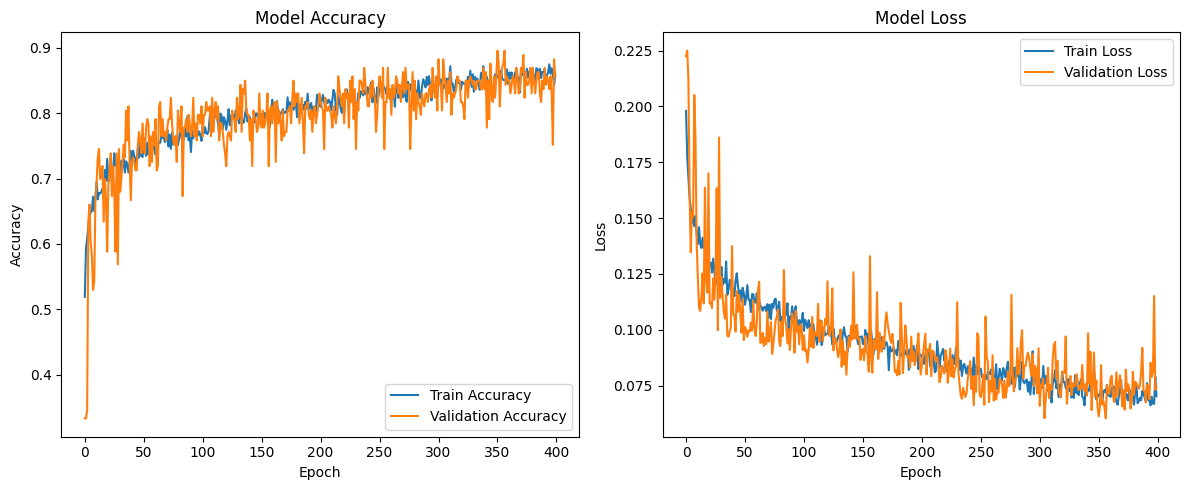

In [18]:
plot_learning_curves(history)

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step


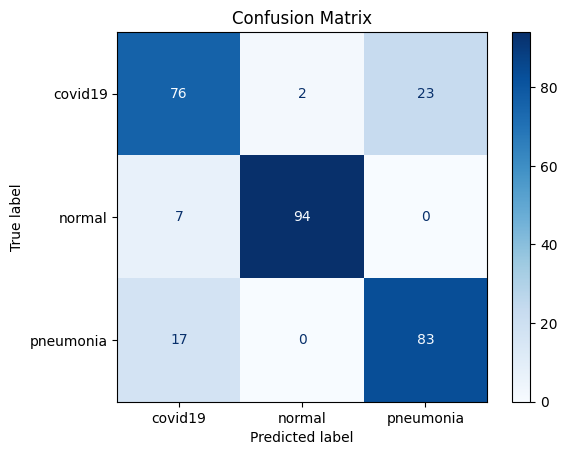

In [19]:
plot_confusion_matrix(model, test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━

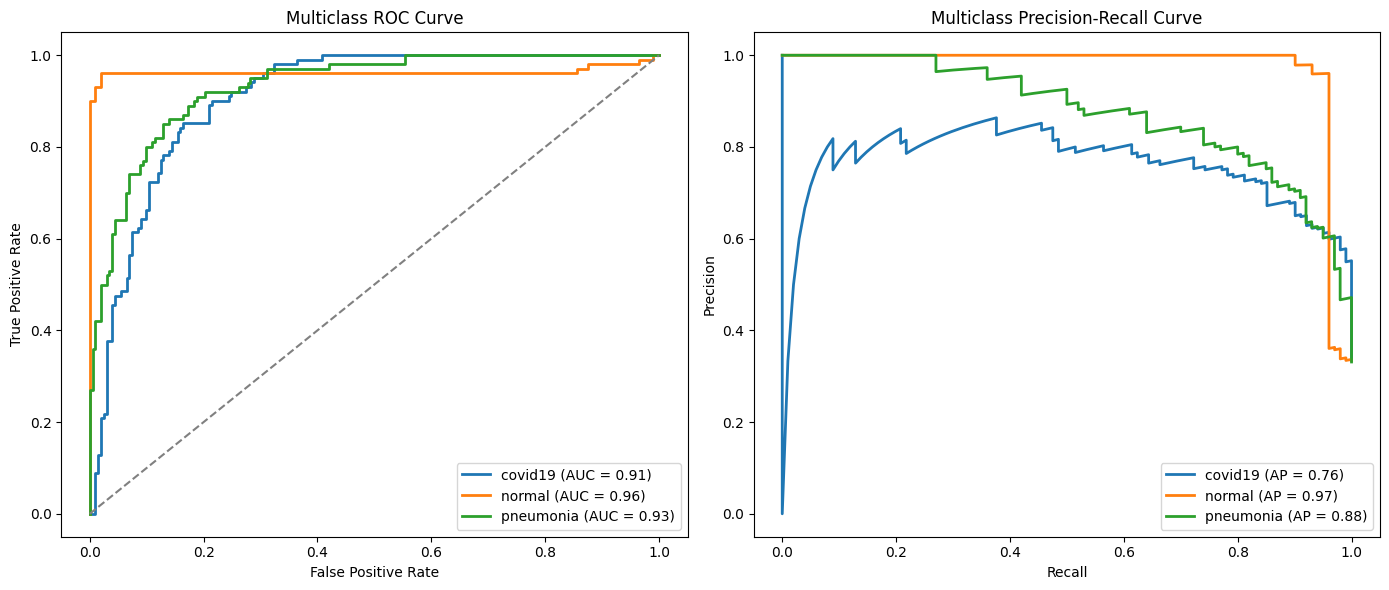

In [20]:
class_labels = ['covid19', 'normal', 'pneumonia']
y_true = []
y_probs = []

for x_batch, y_batch in test_generator:
    preds = model.predict(x_batch)
    y_probs.extend(preds)
    y_true.extend(np.argmax(y_batch, axis=1)) 

    if len(y_true) >= test_generator.samples:
        break

y_true = np.array(y_true)
y_probs = np.array(y_probs)

plot_multiclass_roc_pr(y_true, y_probs, class_labels)

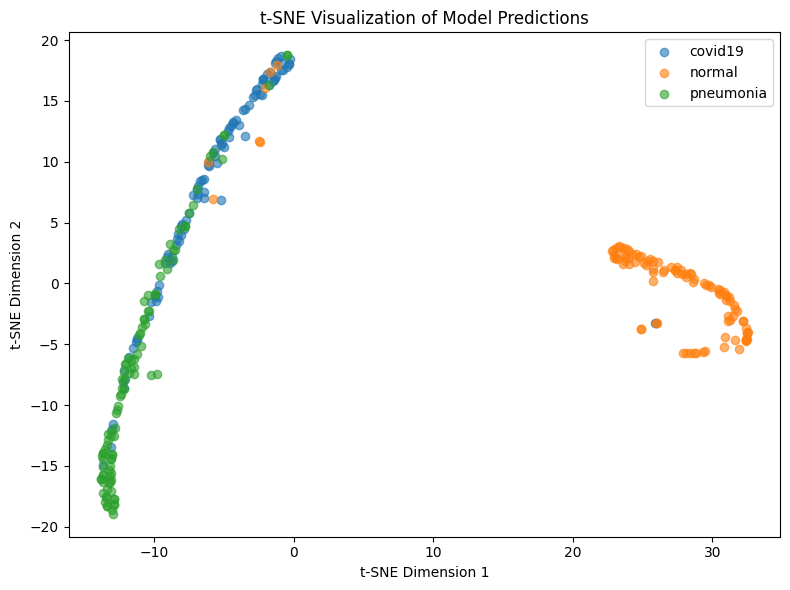

In [21]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(y_probs)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    indices = y_true == i
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=class_names[i], alpha=0.6)

plt.title("t-SNE Visualization of Model Predictions")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.tight_layout()
plt.show()


# Explanatory Techniques

### LIME

  0%|          | 0/500 [00:00<?, ?it/s]

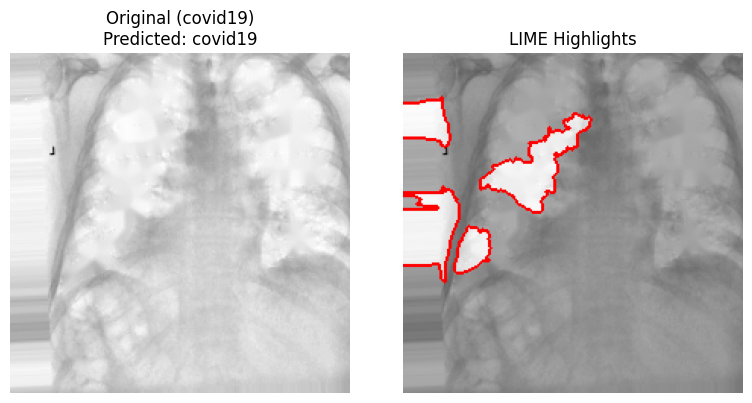

Image: /kaggle/input/feature-selelcted-dataset/test/covid19/image_108.png
Predicted probabilities: {'covid19': 0.9202402, 'normal': 1.1707906e-06, 'pneumonia': 0.079758584}



  0%|          | 0/500 [00:00<?, ?it/s]

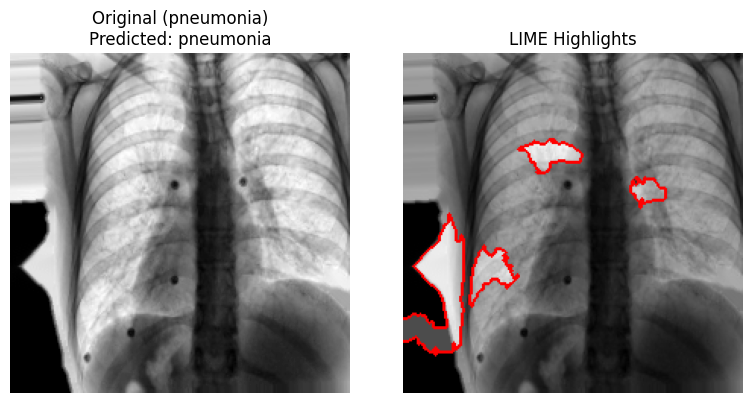

Image: /kaggle/input/feature-selelcted-dataset/test/pneumonia/image_138.png
Predicted probabilities: {'covid19': 0.128775, 'normal': 0.0016463951, 'pneumonia': 0.8695786}



  0%|          | 0/500 [00:00<?, ?it/s]

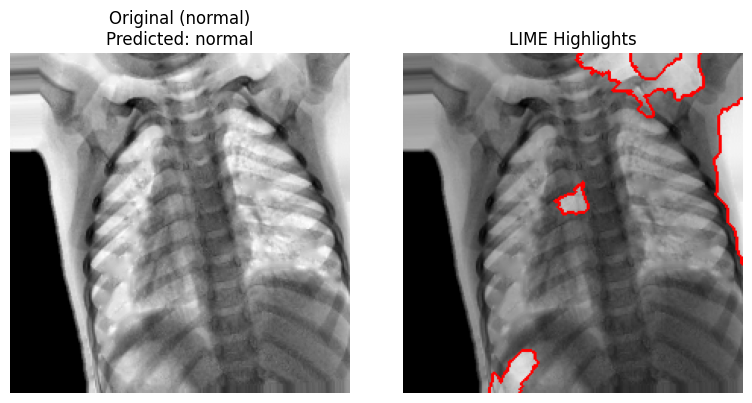

Image: /kaggle/input/feature-selelcted-dataset/test/normal/image_133.png
Predicted probabilities: {'covid19': 0.00042881726, 'normal': 0.99955827, 'pneumonia': 1.2831893e-05}



In [22]:
try:
    image_paths = [
        (os.path.join(test_dir, 'covid19', os.listdir(os.path.join(test_dir, 'covid19'))[4]), 'covid19'),
        (os.path.join(test_dir, 'pneumonia', os.listdir(os.path.join(test_dir, 'pneumonia'))[4]), 'pneumonia'),
        (os.path.join(test_dir, 'normal', os.listdir(os.path.join(test_dir, 'normal'))[4]), 'normal')
    ]
    explain_with_lime(model, image_paths)
except Exception as e:
    print(f"Error loading sample images: {e}")

### GRAD-CAM


Processing image: /kaggle/input/feature-selelcted-dataset/test/covid19/image_108.png
Sample image shape: (224, 224, 3)
Sample image min/max: 0.0 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class: covid19
Predictions: [9.2024022e-01 1.1707906e-06 7.9758584e-02]
Heatmap shape: (2, 2)
Heatmap min/max: 0.25612515 1.0
Plot saved to: /kaggle/working/grad_cam_covid19.png


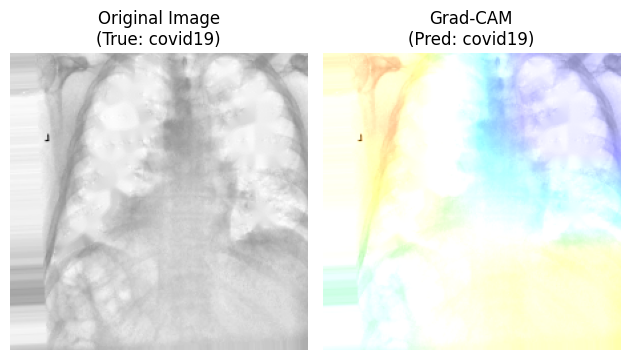


Processing image: /kaggle/input/feature-selelcted-dataset/test/pneumonia/image_138.png
Sample image shape: (224, 224, 3)
Sample image min/max: 0.0 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class: pneumonia
Predictions: [0.128775  0.0016464 0.8695786]
Heatmap shape: (2, 2)
Heatmap min/max: 0.07285442 1.0
Plot saved to: /kaggle/working/grad_cam_pneumonia.png


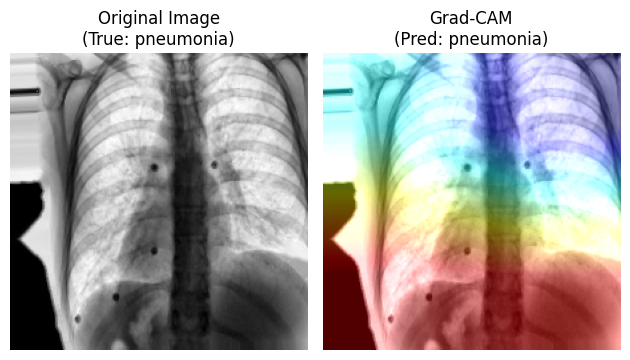


Processing image: /kaggle/input/feature-selelcted-dataset/test/normal/image_133.png
Sample image shape: (224, 224, 3)
Sample image min/max: 0.0 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class: normal
Predictions: [4.2881726e-04 9.9955827e-01 1.2831893e-05]
Heatmap shape: (2, 2)
Heatmap min/max: 0.0 1.0
Plot saved to: /kaggle/working/grad_cam_normal.png


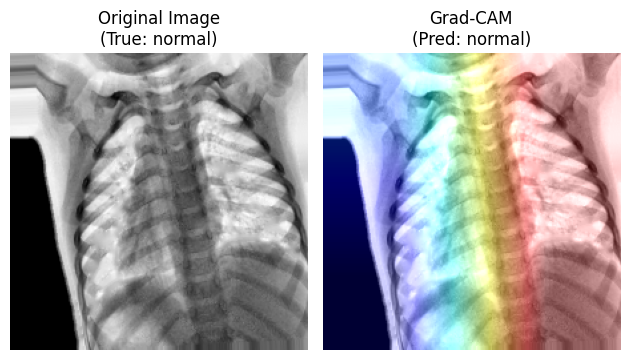

In [23]:
for img_path, class_label in image_paths:
    apply_grad_cam(
        model=model,
        image_path=img_path,
        class_label=class_label,
        class_labels=class_labels,
        last_conv_layer_name='conv2d_19',
        save_dir='.'
    )

### DEEPLIFT

In [24]:
class_labels = ['covid19', 'normal', 'pneumonia']
label_to_index = {label: idx for idx, label in enumerate(class_labels)}

images = []
labels = []

for path, label_str in image_paths:
    img_normalized, _ = preprocess_image(path)  
    if img_normalized is not None:
        images.append(img_normalized)
        labels.append(label_to_index[label_str])

sample_images = np.array(images)
sample_labels = np.array(labels)


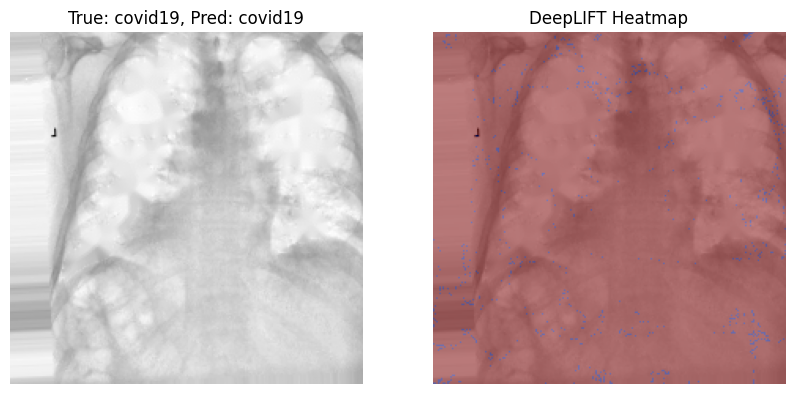

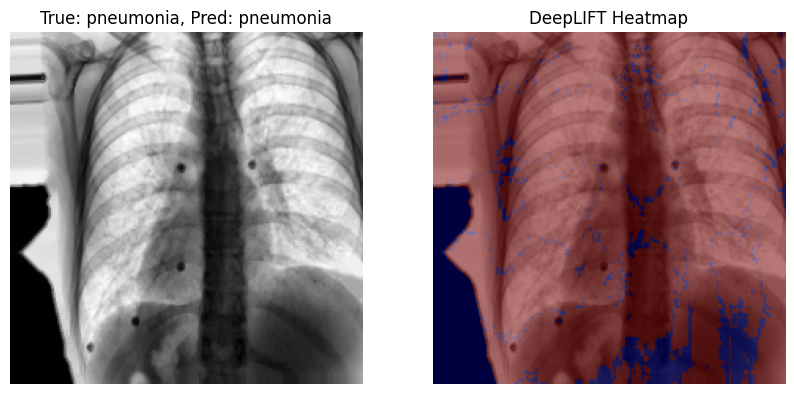

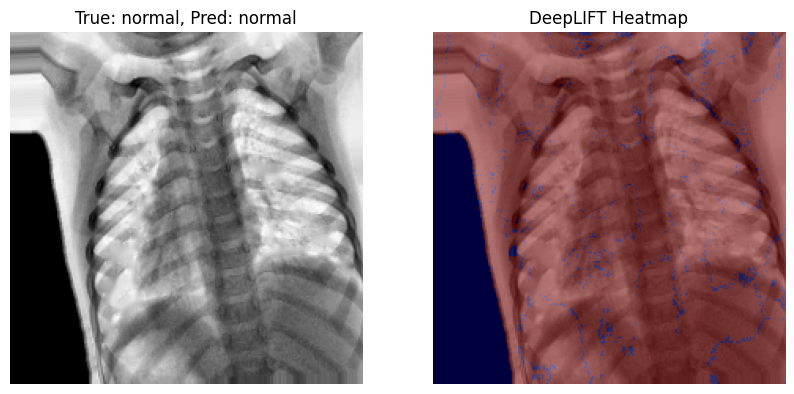

In [25]:

for i in range(len(sample_images)):
    img = sample_images[i:i+1]
    heatmap, pred_class = deeplift(model, img)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title(f"True: {class_labels[labels[i]]}, Pred: {class_labels[pred_class]}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    superimposed_img = display_heatmap(img, heatmap)
    plt.imshow(superimposed_img)
    plt.title("DeepLIFT Heatmap")
    plt.axis('off')
    
    plt.show()

### permutation Importance

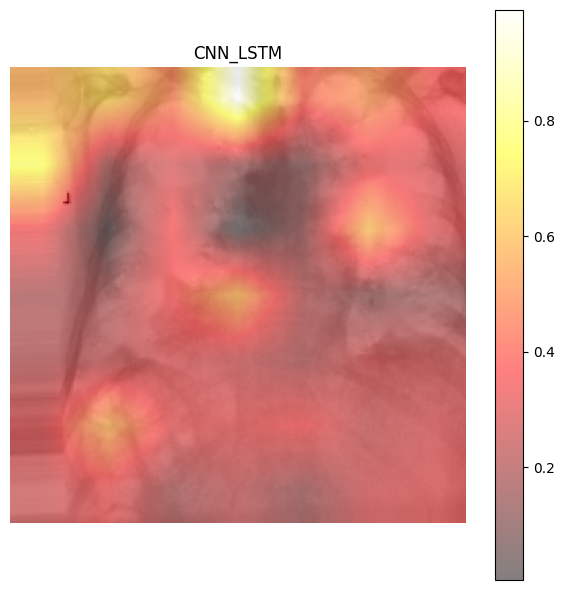

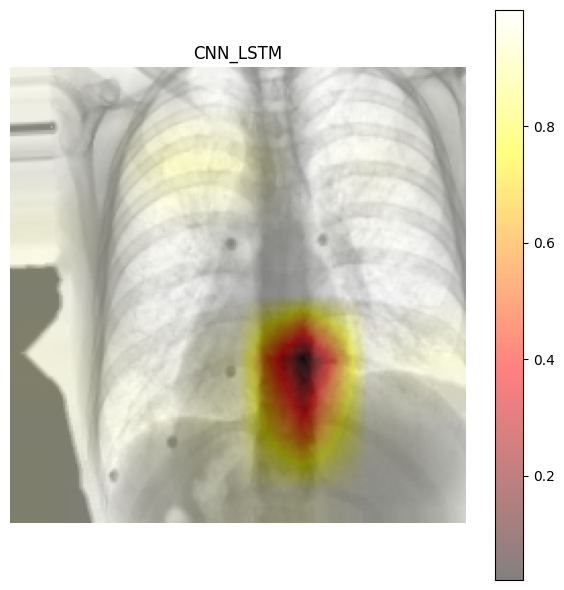

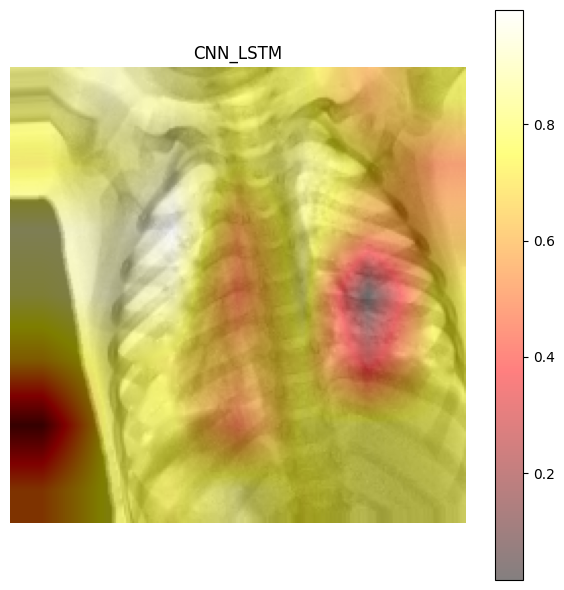

In [26]:
img_covid = sample_images[0]
img_pneumnia = sample_images[1]
img_normal = sample_images[2]



permutation_importance(img_covid, model, class_index=0, model_name="CNN_LSTM", raw_image=img_covid)
permutation_importance(img_pneumnia, model, class_index=1, model_name="CNN_LSTM", raw_image=img_pneumnia)
permutation_importance(img_normal, model, class_index=2, model_name="CNN_LSTM", raw_image=img_normal)
